In [1]:
import sys
sys.path.insert(0, "../spectral_approximate_inference")
import numpy as np
import matplotlib.pyplot as plt
from read_mat import ReadMat
import pandas as pd
import time
import scipy.io as sio
import math
import cffi

In [2]:
sys.path.insert(0, "../spectral_approximate_inference/gm")
sys.path.insert(0, "../spectral_approximate_inference/inference")
from gm import *
from factor import *
from ising_model import *
from rank1_ising import Rank1Ising
import scipy.io as sio

In [ ]:
ffi = cffi.FFI()
ffi.cdef('float mixing(int n, int k, float *A, float *h, float *V, float eps, int max_iter);'
        'float mixing_plus(int n, int d, int k, float *A, float *h, float *Z, float eps, int max_iter);')

ffi.set_source('_part', r'''
        #include "part.h"
''', sources=['part.c'], source_extension='.c',
   extra_compile_args=['-O3'],
)

ffi.compile(verbose=True)
import _part

In [70]:
# Convert vector to string
def get_string_from_vector(v):
    ret = ""
    for digit in v:
        if digit == -1:
            ret += "0"
        else:
            ret += "1"
    return ret

# Sample n vectors uniformly on unit sphere
def sample_unit_sphere(k, n):
    ret = np.random.normal(0, 1, size=(k, n))
    ret = ret / np.linalg.norm(ret, axis=0, keepdims=True)
    return ret

In [4]:
# Run mixing method
def mixing(A, h, V, max_iter=100, eps=0):
    n = A.shape[0]
    d = V.shape[1]
    assert A.shape[1] == n and h.shape[0] == n and h.shape[1] == d
    A = A.astype(np.float32)
    h = h.astype(np.float32)
    _V = V.astype(np.float32)

    diff = _part.lib.mixing(n, d, ffi.from_buffer('float[]', A), ffi.from_buffer('float[]', h), 
                            ffi.from_buffer('float[]', _V), eps, max_iter)
    V[:] = _V
    return diff

# Run the mixing_plus method
def mixing_plus(A, h, Z, k, max_iter=100, eps=0):
    n = A.shape[0]
    d = Z.shape[1]
    m = d // k
    assert A.shape[1] == n and h.shape[0] == n and h.shape[1] == d
    assert d % k == 0
    A = A.astype(np.float32)
    h = h.reshape((n,m,k)).transpose(0,2,1)
    h = np.ascontiguousarray(h, dtype=np.float32)
    _Z = np.ascontiguousarray(Z.reshape((n,m,k)).transpose(0,2,1)).astype(np.float32)

    diff = _part.lib.mixing_plus(n, d, k, ffi.from_buffer('float[]', A), ffi.from_buffer('float[]', h), ffi.from_buffer('float[]', _Z), eps, max_iter)
    Z[:] = _Z.reshape((n,k,m)).transpose(0,2,1).reshape((n,d))
    return diff

In [6]:
# Generate all (k)^n strings in support of MRF
def generate_strings(n, k):
    assert k >= 2 and k < 10
    if n == 1:
        return [str(i) for i in range(k)]
    ret = []
    all_smaller_strings = generate_strings(n-1, k)
    for i in range(k):
        ret.extend([str(i) + s for s in all_smaller_strings])
    return ret

# Convert vector to string
def get_string_from_vector(v):
    ret = ""
    for digit in v:
        assert digit >=0 and digit < 10
        ret += str(digit)
    return ret

# Sample n vectors uniformly on unit sphere
def sample_unit_sphere(n, d):
    ret = np.random.normal(0, 1, size=(n, d))
    ret = ret / np.linalg.norm(ret, axis=1, keepdims=True)
    return ret

# Get f = \sum_{ij}Aij\delta(i, j)/2 + \sum_i\sum_k b_ik\delta(i, k)
def get_f(A, h, s):
    k = h.shape[1]
    n = A.shape[0]
    if type(s) == str:
        s = np.array(list(s), dtype=int)
    delta = np.zeros((k, n))
    delta[s, np.arange(n)] = 1
    sm = np.sum((delta.T @ delta) * A) - np.sum(A) / 2
    truth = np.eye(k)
    sm += 2 * np.sum((delta.T @ truth) * h) - np.sum(h)
    return sm

# Multiply V by the matrix S efficiently
def mul_S(s, V):
    d = V.shape[1]
    k = s.shape[0]
    assert d % k == 0
    return (V.reshape(-1, d // k, k) @ s).reshape(V.shape)

# Rounding in the multi-class case
def obtain_rounded_v(V, B):
    n = V.shape[0]
    d = V.shape[1]
    k = B.shape[0]
    r = np.random.normal(0, 1, size=(k, d))
    r = r / np.linalg.norm(r, axis=1, keepdims=True)
    
    rounded_v = np.argmax(V @ r.T, axis=1)
    rounded_v_one_hot = np.zeros((n, k))
    rounded_v_one_hot[np.arange(n), rounded_v] = 1
    
    # shape(num_classes): saying that r:i maps to S:j
    r_to_B = np.argmax(r @ B.T, axis=1)
    transformation_matrix = np.zeros((k, k))
    transformation_matrix[np.arange(k), r_to_B] = 1
    rounded_v_one_hot = rounded_v_one_hot @ transformation_matrix
    rounded_v = np.argmax(rounded_v_one_hot, axis=1)
    
    return rounded_v

<h2> Our method

In [7]:
# Compute the log-sum-exp of a list safely
def LSE(y):
    max_y = np.max(y)
    return np.log(np.sum(np.exp(np.array(y)-max_y))) + max_y

# Routine to compute partition function: Algorithm 4 in paper
def compute_logZ_sdp(A, h, rounding_iters=10000, method="mixing"):
    n = len(A)
    k = h.shape[1]
    
    if method == "mixing-plus":
        d = int(np.ceil(k * np.sqrt(2*n) + 1))

        while(d % k != 0):
            d += 1
        assert d >= k

        C_hat = (k/(k-1))*np.eye(k) - (1/(k-1))*np.full((k, k), 1)
        U, Sigma, Ut = np.linalg.svd(C_hat)
        s = (np.diag(Sigma) ** 0.5) @ Ut

        Z = np.random.normal(0, 1, size=(n, d))
        Z = np.abs(Z)
        Z = Z / np.linalg.norm(Z, axis=1, keepdims=True)

        B = np.zeros((k, d))
        B[np.arange(k), np.arange(k)] = 1

        _h = h @ B

        Z = np.asarray(Z, order='C')
        A = np.asarray(A, order='C')
        _h = np.asarray(_h, order='C') 

        diff = mixing_plus(A, _h, Z, k, max_iter=100, eps=0)

        V = mul_S(s.T, Z)
        B = mul_S(s.T, B)
    elif method == "mixing":
        d = int(np.ceil(np.sqrt(2*(n+k*(k+1)/2)) + 1))
        
        V = sample_unit_sphere(n, d)
        B = np.zeros((k, d))
        B[np.arange(k), np.arange(k)] = 1
        r0 = np.sum(B, axis=0) / k
        c = np.sqrt((k - 1) / k)
        B = (B - r0[np.newaxis, :]) / c
        _h = h @ B
        V = np.asarray(V, order='C')
        A = np.asarray(A, order='C')
        _h = np.asarray(_h, order='C')
        diff = mixing(A, _h, V)
    
    sdp_logZ = np.trace(A.T @ (V @ V.T)) / 2  + np.sum((V @ B.T) * h)
    
    s_list = {}
    f_list = []
    for _ in range(rounding_iters):
        x = obtain_rounded_v(V, B)
        f = get_f(A, h, x)
        s = get_string_from_vector(x)
        if s not in s_list:
            s_list[s] = 1
            f_list.append(f)

    rem = np.log(1-np.exp(np.log(len(f_list))-n*np.log(k)))

    y_list = []
    while True:
        if len(y_list) >= rounding_iters: break
        x = np.random.choice(k, n, replace=True)
        s = get_string_from_vector(x)
        if s in s_list: continue
        f = get_f(A, h, x)
        log_q = -n * np.log(k) - rem
        f_minus_log_q = f - log_q
        y_list.append(f_minus_log_q)
    sm = LSE(y_list) - np.log(len(y_list))
    sm = LSE([sm]+f_list)

    rounded_logZ = sm
    return sdp_logZ, rounded_logZ

<h2> Geometric method by Wang et al. ICLR 2014

In [8]:
def compute_logZ_sdp_iclr(A, h, rounding_iters=10000):
    # Convert vector to string
    def get_string_from_vector(v):
        ret = ""
        for digit in v:
            if digit == -1:
                ret += "0"
            else:
                ret += "1"
        return ret
    
    # Sample n vectors uniformly on unit sphere
    def sample_unit_sphere(d, n):
        ret = np.random.normal(0, 1, size=(d, n))
        ret = ret / np.linalg.norm(ret, axis=0, keepdims=True)
        return ret

    def get_angle(cos_theta):
        assert -1 <= cos_theta
        assert cos_theta <= 1
        return math.acos(cos_theta)
    
    def get_perp_vector(v):
        return np.array((-v[1], v[0]))
    
    # Run the mixing method for optimization
    def mixing_method(V, A, h, max_iters=100):
        n = len(A)
        d = V.shape[0]
        for _ in range(max_iters):
            for i in range(n):
                accumulation = np.zeros(d)
                accumulation[0] = h[i]
                for j in range(n):
                    accumulation = accumulation + A[i, j] * V[:, j]
                accumulation = accumulation / np.linalg.norm(accumulation)
                V[:, i] = accumulation
        return V
    
    n = len(A)
    d = 2
    V = sample_unit_sphere(d, n)
    
    # Setting v_t = e_d
    v_t = np.zeros(d)
    v_t[-1] = 1
    
    # Perform mixing method on V
    V = mixing_method(V, A, h)
    
    sdp_logZ = np.trace(A.T @ (V.T @ V)) / 2 + (h.T @ (V.T @ v_t)) # <A, V^TV> / 2 + <h, V^Tv_t>
    
    angles_list = [0, np.pi]
    for i in range(V.shape[1]):
        perp_vec = get_perp_vector(V[:, i])
        if perp_vec[1] < 0:
            perp_vec = -perp_vec
        cos_theta = perp_vec.T @ np.array((1, 0))
        angles_list.append(get_angle(cos_theta))
    
    angles_list = sorted(angles_list)
    
    p_v = {}
    for i in range(len(angles_list) - 1):
        angle = (angles_list[i] + angles_list[i+1]) / 2
        r = np.array((np.cos(angle), np.sin(angle)))
        rounded_v = np.array([np.sign((V[:, j].T @ r) * (v_t.T @ r)) for j in range(n)])
        s = get_string_from_vector(rounded_v)
        p_v[s] = (angles_list[i+1] - angles_list[i]) / np.pi # pi coz have to multiply prob by 2
    
    f_list = []
    mx = -np.inf
    for _ in range(rounding_iters):
        r = sample_unit_sphere(d, 1)
        r = np.reshape(r, -1)
        x = np.array([np.sign((V[:, j].T @ r) * (v_t.T @ r)) for j in range(n)])
        f = (x.T @ A @ x) / 2 + (h.T @ x)
        s = get_string_from_vector(x)
        assert s in p_v
        f_list.append(f - np.log(p_v[s]))
        mx = max(mx, f - np.log(p_v[s]))
    
    f_list = np.array(f_list)
    f_list = f_list - mx
    rounded_logZ = np.log(np.sum(np.exp(f_list)))
    rounded_logZ += mx
    rounded_logZ -= np.log(rounding_iters)
 
    return sdp_logZ, rounded_logZ

<h2> ER graph n=20

In [13]:
mat = sio.loadmat('../data/ER_5_data.mat')
coupling_data = mat['coupling']
bias_data = mat['bias']
logZ_data = mat['logZ']
print(coupling_data.shape, bias_data.shape, logZ_data.shape)
n = coupling_data.shape[0]
cw_len = coupling_data.shape[-2]
num_samples = coupling_data.shape[-1]

# Required to run Park et al; refer to spectral_approximate_inference/matlab_code/check.m
# on how to compute these matrices
US_mat = sio.loadmat('../data/ER_correct_5_Ux_Sx.mat')
Ux = US_mat["Ux"]
Sx = US_mat["Sx"]
print(Ux.shape, Sx.shape)

(20, 20, 21, 100) (20, 21, 100) (21, 100)
(21, 21, 21, 100) (21, 21, 21, 100)


In [14]:
# Run Spectral AI (Park et al.) on all the problem instances
rank1_error = []
time_rank1_list = []
for cw in range(cw_len):
    diff_rank1 = []
    for sample in range(num_samples):
        print("CW =", cw, " Sample number =", sample, end="\r")
        A = coupling_data[:, :, cw, sample]
        h = bias_data[:, cw, sample]
        ground_truth = logZ_data[cw, sample]
        im = IsingModel(h, A)
        
        V, s = Ux[:, :, cw, sample], np.diag(Sx[:, :, cw, sample])
        st = time.time()
        rank = Rank1Ising(im, V, s)
        diff_rank1.append(np.abs(ground_truth - rank.run_rank1()))
        time_rank1_list.append(time.time() - st)
    rank1_error.append(np.mean(diff_rank1))
    
# Run our algorithm on all the problem instances
sdp_r = []
t_list = []
rounding_iters = 500
for i in range(cw_len):
    diff_sdp_r = []
    for sample in range(num_samples):
        print("CW =", i, " Sample number =", sample, end="\r")
        A = coupling_data[:, :, i, sample]
        h = np.zeros((n, 2))
        h[:, 0] = bias_data[:, i, sample]
        ground_truth = logZ_data[i, sample]
        s = time.time()
        _, rounded_logZ = compute_logZ_sdp(A, h, rounding_iters=rounding_iters, method="mixing")
        t_list.append(time.time() - s)
        diff_sdp_r.append(np.abs(ground_truth - rounded_logZ))
    sdp_r.append(np.mean(diff_sdp_r))

# Run the method by Wang et al. on all the problem instances
sdp_iclr_error = []
time_sdp_iclr_list = []
for i in range(cw_len):
    diff_sdp_iclr = []
    for sample in range(num_samples):
        print("CW =", i, " Sample number =", sample, end="\r")
        A = coupling_data[:, :, i, sample]
        h = bias_data[:, i, sample]
        ground_truth = logZ_data[i, sample]
        s = time.time()
        _, sdp_iclr_estimate = compute_logZ_sdp_iclr(A, h, rounding_iters=500)
        time_sdp_iclr_list.append(time.time() - s)
        diff_sdp_iclr.append(np.abs(ground_truth - sdp_iclr_estimate))
    sdp_iclr_error.append(np.mean(diff_sdp_iclr))

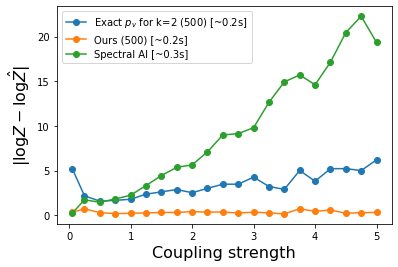

In [17]:
x_axis = np.arange(0, 5.25, 0.25)
x_axis[0] = 0.05

plt.plot(x_axis, sdp_iclr_error, marker="o", label="Exact $p_v$ for k=2 (500) [~0.2s]")
plt.plot(x_axis, sdp_r, marker="o", label="Ours (500) [~0.2s]")
plt.plot(x_axis, rank1_error, marker="o", label="Spectral AI [~0.3s]")
plt.xticks([0, 1, 2, 3, 4, 5], rotation="horizontal")
plt.legend(loc="upper left")
# plt.xticks(cw_range, rotation="vertical")
plt.xlabel("Coupling strength", fontsize=16)
plt.ylabel("$|\log Z - \log \hat{Z}$|", fontsize=16)
plt.show()

<h2> Complete graph n=20

In [18]:
mat = sio.loadmat('../data/20complete_dataset')
coupling_data = mat['A']
bias_data = mat['h']
logZ_data = mat['logZ']
cw_len = coupling_data.shape[-2]
num_samples = coupling_data.shape[-1]
n = coupling_data.shape[0]
print(cw_len, num_samples, n)

21 100 20


In [21]:
# Run Spectral AI (Park et al.) on all the problem instances
rank1_error = []
time_rank1_list = []
for cw in range(1):
    diff_rank1 = []
    for sample in range(1):
        print("CW =", cw, " Sample number =", sample, end="\r")
        A = coupling_data[:, :, cw, sample]
        h = bias_data[:, cw, sample]
        ground_truth = logZ_data[cw, sample]
        im = IsingModel(h, A)
        
        V, s = Ux[:, :, cw, sample], np.diag(Sx[:, :, cw, sample])
        st = time.time()
        rank = Rank1Ising(im, V, s)
        diff_rank1.append(np.abs(ground_truth - rank.run_rank1()))
        time_rank1_list.append(time.time() - st)
    rank1_error.append(np.mean(diff_rank1))

# Run our algorithm on all the problem instances
sdp_r = []
t_list = []
rounding_iters = 500
for i in range(1):
    diff_sdp_r = []
    for sample in range(1):
        print("CW =", i, " Sample number =", sample, end="\r")
        A = coupling_data[:, :, i, sample]
        h = np.zeros((n, 2))
        h[:, 0] = bias_data[:, i, sample]
        ground_truth = logZ_data[i, sample]
        s = time.time()
        _, rounded_logZ = compute_logZ_sdp(A, h, rounding_iters=rounding_iters, method="mixing-plus")
        t_list.append(time.time() - s)
        diff_sdp_r.append(np.abs(ground_truth - rounded_logZ))
    sdp_r.append(np.mean(diff_sdp_r))

# Run the method by Wang et al. on all the problem instances
sdp_iclr_error = []
time_sdp_iclr_list = []
for i in range(1):
    diff_sdp_iclr = []
    for sample in range(1):
        print("CW =", i, " Sample number =", sample, end="\r")
        A = coupling_data[:, :, i, sample]
        h = bias_data[:, i, sample]
        ground_truth = logZ_data[i, sample]
        s = time.time()
        _, sdp_iclr_estimate = compute_logZ_sdp_iclr(A, h, rounding_iters=500)
        time_sdp_iclr_list.append(time.time() - s)
        diff_sdp_iclr.append(np.abs(ground_truth - sdp_iclr_estimate))
    sdp_iclr_error.append(np.mean(diff_sdp_iclr))

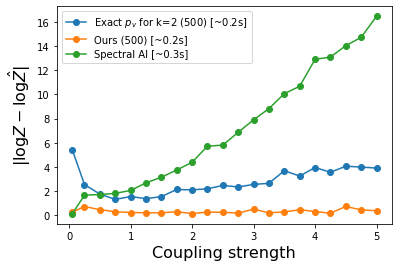

In [23]:
x_axis = np.arange(0, 5.25, 0.25)
x_axis[0] = 0.05

plt.plot(x_axis, sdp_iclr_error, marker="o", label="Exact $p_v$ for k=2 (500) [~0.2s]")
plt.plot(x_axis, sdp_r, marker="o", label="Ours (500) [~0.2s]")
plt.plot(x_axis, rank1_error, marker="o", label="Spectral AI [~0.3s]")
plt.xticks([0, 1, 2, 3, 4, 5], rotation="horizontal")
plt.legend(loc="upper left")
# plt.xticks(cw_range, rotation="vertical")
plt.xlabel("Coupling strength", fontsize=16)
plt.ylabel("$|\log Z - \log \hat{Z}$|", fontsize=16)
plt.show()

<h2> AIS

In [7]:
# p(x) \propto \exp(x^TAx/2 + h^Tx), x \in {-1, 1}^n
def gibbs_sampling(A, h, x, T, num_cycles=10):
    n = len(x)
    for cycle in range(num_cycles):
        for i in range(n):
            p = 1 / (1 + np.exp(- 2 * (A[i, :].T @ x +  h[i]) / T)) # p(x_i=1|x_{-i})
            if np.random.rand() < p:
                x[i] = 1
            else:
                x[i] = -1
    return x

def log_f_k(x, k, inv_temps, A, h):
    n = len(x)
    weight_on_uniform = (inv_temps[k] - 1) * n * np.log(2)
    weight_on_true = inv_temps[k] * ((x.T @ A @ x) / 2 + h.T @ x)
    return weight_on_uniform + weight_on_true

def ais(A, h, num_samples=500, K=100, num_cycles=10):
    n = len(A)
    inv_temps = np.linspace(0, 1, K)
    sm = 0
    log_w_list = []
    mx = -np.inf
    for i in range(num_samples):  
        # print(i)
        x = np.random.choice([-1, 1], size=n, replace=True)
        w = 0
        for k in range(1, K):
            w = w + log_f_k(x, k, inv_temps, A, h) - log_f_k(x, k-1, inv_temps, A, h)
            x = gibbs_sampling(A, h, x, 1 / inv_temps[k], num_cycles=num_cycles)
        log_w_list.append(w)
        mx = max(mx, w)

    log_w_list = [elem - mx for elem in log_w_list]
    logZ = mx + np.log(np.sum(np.exp(log_w_list))) - np.log(num_samples)
    return logZ

In [8]:
# Run AIS to compute logZ on all problem instances
K = 25
num_samples_ais = 500
num_cycles = 1

ais_error = []
time_ais_list = []
for cw in range(cw_len):
    diff_ais = []
    for sample in range(num_samples):
        print("CW =", cw, " Sample number =", sample, end="\r")
        A = coupling_data[:, :, cw, sample]
        h = bias_data[:, cw, sample]
        # ground_truth = partition_function_ground_truth(A, h)
        ground_truth = logZ_data[cw, sample]
        s = time.time()
        ais_estimate = ais(A, h, num_samples=num_samples_ais, K=K, num_cycles=num_cycles)
        time_ais_list.append(time.time() - s)
        diff_ais.append(np.abs(ground_truth - ais_estimate))
    ais_error.append(np.mean(diff_ais))

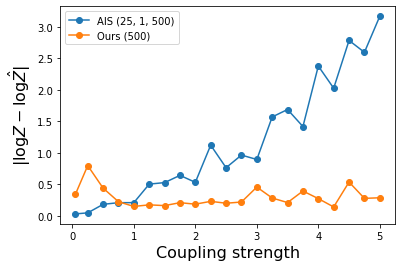

In [11]:
x_axis = np.arange(0, 5.25, 0.25)
x_axis[0] = 0.05

plt.plot(x_axis, ais_error, marker="o", label="AIS (25, 1, 500)")
plt.plot(x_axis, sdp_r, marker="o", label="Ours (500)")
plt.xticks([0, 1, 2, 3, 4, 5], rotation="horizontal")
plt.legend(loc="upper left")
# plt.xticks(cw_range, rotation="vertical")
plt.xlabel("Coupling strength", fontsize=16)
plt.ylabel("$|\log Z - \log \hat{Z}$|", fontsize=16)
plt.show()